# Traditional Approach for Training

In this notebook, we apply the traditional approach of training a deep neural network model for predicting steering angle based on the input images.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import ntpath

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import warnings
warnings.filterwarnings("ignore")

## Data Pre-Processing

In [2]:
data_path = 'data'
path = os.path.join(data_path,'driving_log.csv')
data = pd.read_csv(path)

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [4]:
center = data[data.columns[0]].values
left = data[data.columns[1]].values
right = data[data.columns[2]].values
steering = data[data.columns[3]].values

no_of_examples = len(steering)
print("Total Number of Samples :", no_of_examples)

Total Number of Samples : 8036


In [5]:
image_path = 'IMG'
image_path = os.path.join(data_path, image_path)

In [6]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

In [7]:
x = []
y = []

steer_adjust_factor = 0.2
IMAGE_HEIGHT = 100 
IMAGE_WIDTH = 100

for i in range(no_of_examples):
    for choice in range(3):
        if choice == 0: # Center Image
            img = cv2.imread(os.path.join(image_path, center[i]))
            steering_angle = steering[i]
        elif choice == 1: # Left Image
            img = cv2.imread(os.path.join(image_path, left[i]))
            steering_angle = steering[i] + steer_adjust_factor
        elif choice == 2: # Right Image
            img = cv2.imread(os.path.join(image_path, right[i]))
            steering_angle = steering[i] - steer_adjust_factor
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
        img = img[50:,:]
        img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        x.append(img)
        y.append(steering_angle)
        
        flipped_img, flipped_steering_angle = random_flip(img, steering_angle)
                
        x.append(flipped_img)
        y.append(flipped_steering_angle)

x = np.array(x)
x = np.reshape(x, [x.shape[0], x.shape[1], x.shape[2], 1])

y = np.array(y)
y = np.reshape(y, [y.shape[0],1])

print("x shape :", x.shape)
print("y shape :", y.shape)

x shape : (48216, 100, 100, 1)
y shape : (48216, 1)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_size = x_train.shape[0]
x_test_size = x_test.shape[0]

print("x_train size :", x_train_size)
print("x_test size :", x_test_size)

x_train size : 38572
x_test size : 9644


In [9]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [10]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [11]:
x_train_tensor = torch.Tensor(x_train).permute(0, 3, 1, 2)  # Change channels last to channels first
y_train_tensor = torch.Tensor(y_train)

x_test_tensor = torch.Tensor(x_test).permute(0, 3, 1, 2)  # Change channels last to channels first
y_test_tensor = torch.Tensor(y_test)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=3, pin_memory=True)

train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Model

In [12]:
class CNNModel(nn.Module):
    def __init__(self, height, width):
        super(CNNModel, self).__init__()
        
        self.height = height
        self.width = width
        
        # Input normalization
        self.norm = nn.BatchNorm2d(1)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * (height // 16) * (width // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        # Dropout and Batch normalization
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.batchnorm1(self.fc1(x))
        x = self.batchnorm2(self.fc2(x))
        x = self.batchnorm3(self.fc3(x))
        x = self.fc4(x)
        return x

In [13]:
model = CNNModel(IMAGE_HEIGHT, IMAGE_WIDTH)

In [14]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [15]:
print(summary(model, input_size=(1, IMAGE_HEIGHT, IMAGE_WIDTH)))

Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                            320
├─Conv2d: 1-3                            9,248
├─Conv2d: 1-4                            18,496
├─Conv2d: 1-5                            36,928
├─Conv2d: 1-6                            73,856
├─Conv2d: 1-7                            147,584
├─MaxPool2d: 1-8                         --
├─Linear: 1-9                            2,359,808
├─Linear: 1-10                           131,328
├─Linear: 1-11                           16,448
├─Linear: 1-12                           65
├─Dropout: 1-13                          --
├─BatchNorm1d: 1-14                      1,024
├─BatchNorm1d: 1-15                      512
├─BatchNorm1d: 1-16                      128
Total params: 2,795,747
Trainable params: 2,795,747
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─Conv2d: 1-2                         

In [16]:
epochs = 50
lr = 0.0001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [17]:
# Training Helper Function to Format Time
def format_time(seconds):
  days = int(seconds / 3600/24)
  seconds = seconds - days*3600*24
  hours = int(seconds / 3600)
  seconds = seconds - hours*3600
  minutes = int(seconds / 60)
  seconds = seconds - minutes*60
  secondsf = int(seconds)
  seconds = seconds - secondsf
  millis = int(seconds*1000)

  f = ''
  i = 1
  if days > 0:
    f += str(days) + 'D'
    i += 1
  if hours > 0 and i <= 2:
    f += str(hours) + 'h'
    i += 1
  if minutes > 0 and i <= 2:
    f += str(minutes) + 'm'
    i += 1
  if secondsf > 0 and i <= 2:
    f += str(secondsf) + 's'
    i += 1
  if millis > 0 and i <= 2:
    f += str(millis) + 'ms'
    i += 1
  if f == '':
    f = '0ms'
  return f

In [18]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    start_time = time.time()
    
    # Training
    train_running_loss = 0.0
    
    model.train()
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item() * inputs.size(0)
    
    train_epoch_loss = train_running_loss / x_train_size
    train_losses.append(train_epoch_loss)
    
    # Evaluation
    test_running_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)

    test_epoch_loss = test_running_loss / x_test_size
    test_losses.append(test_epoch_loss)

    cur_time = time.time()
    epoch_time = cur_time - start_time
    
    print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_epoch_loss:.4f} | Test Loss: {test_epoch_loss:.4f}')
    print(f'Time Taken : {format_time(epoch_time)}')
    print('')

Epoch [1/50] | Train Loss: 0.0276 | Test Loss: 0.0110
Time Taken : 14s106ms

Epoch [2/50] | Train Loss: 0.0124 | Test Loss: 0.0103
Time Taken : 13s333ms

Epoch [3/50] | Train Loss: 0.0115 | Test Loss: 0.0101
Time Taken : 13s275ms

Epoch [4/50] | Train Loss: 0.0111 | Test Loss: 0.0100
Time Taken : 13s319ms

Epoch [5/50] | Train Loss: 0.0109 | Test Loss: 0.0097
Time Taken : 13s321ms

Epoch [6/50] | Train Loss: 0.0105 | Test Loss: 0.0092
Time Taken : 13s277ms

Epoch [7/50] | Train Loss: 0.0103 | Test Loss: 0.0097
Time Taken : 13s231ms

Epoch [8/50] | Train Loss: 0.0098 | Test Loss: 0.0091
Time Taken : 13s309ms

Epoch [9/50] | Train Loss: 0.0098 | Test Loss: 0.0088
Time Taken : 13s310ms

Epoch [10/50] | Train Loss: 0.0095 | Test Loss: 0.0087
Time Taken : 13s338ms

Epoch [11/50] | Train Loss: 0.0092 | Test Loss: 0.0086
Time Taken : 13s338ms

Epoch [12/50] | Train Loss: 0.0090 | Test Loss: 0.0085
Time Taken : 13s246ms

Epoch [13/50] | Train Loss: 0.0086 | Test Loss: 0.0084
Time Taken : 13s31

In [19]:
# Helper Function to Plot Losses
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train Losses')
    plt.plot(test_losses, label='Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Loss vs. No. of epochs')

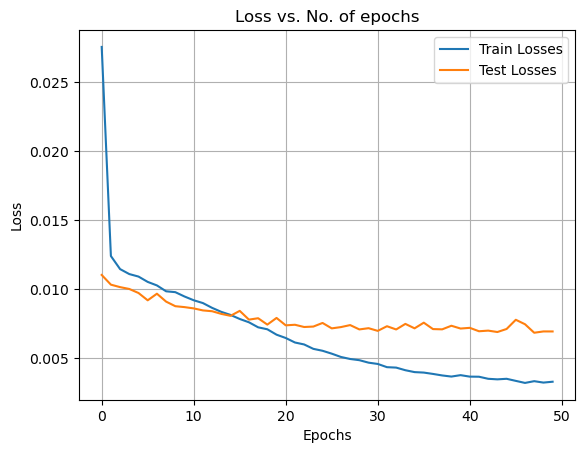

In [20]:
plot_losses(train_losses, test_losses)

In [21]:
# Saving model state
state = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses,
        'epochs': epochs,
        'lr': lr,
    }

torch.save(state, 'traditional_approach.pth')